# Imports

In [2]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.graph_objs as go

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

from torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data Loading

In [5]:
data = pd.read_csv("./data/online_shoppers_intention.csv")
csv_data = pd.read_csv("./data/online_shoppers_intention.csv")
data.fillna(0, inplace=True)
related_bounce = data.iloc[:,[5,6]]

# print(related_bounce)
related_bounce = related_bounce.values
print(related_bounce)

[[0.0000000e+00 2.0000000e-01]
 [6.4000000e+01 0.0000000e+00]
 [0.0000000e+00 2.0000000e-01]
 ...
 [1.8425000e+02 8.3333333e-02]
 [3.4600000e+02 0.0000000e+00]
 [2.1250000e+01 0.0000000e+00]]


In [6]:
data.head()
data["VisitorType"].unique()
# dataFrame = data.drop(columns=['BounceRates'])
# dataFrame

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

# Data cleaning

In [7]:
df_customers = data["VisitorType"]
df_customers_dict = {"New_Visitor":0,
                     "Returning_Visitor":1,
                     "Other":0}
df_customers = df_customers.map(lambda x: df_customers_dict[x])
df = data.drop(columns=['OperatingSystems', "Browser"])
# hot_encoded_dict = 
df = pd.get_dummies(df, columns=["Month"])
df["VisitorType"] = df["VisitorType"].map(lambda x: df_customers_dict[x])
df = df.map(lambda x: int(x) if isinstance(x, bool) else x)
df


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,0,1,0,0,0,0,0,0,0,0
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,0,0,0,0,0,0,0,1,0,0
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,0,0,0,0,0,0,0,1,0,0
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,0,0,0,0,0,0,0,1,0,0


# Clustering with K-Elbow and K-means

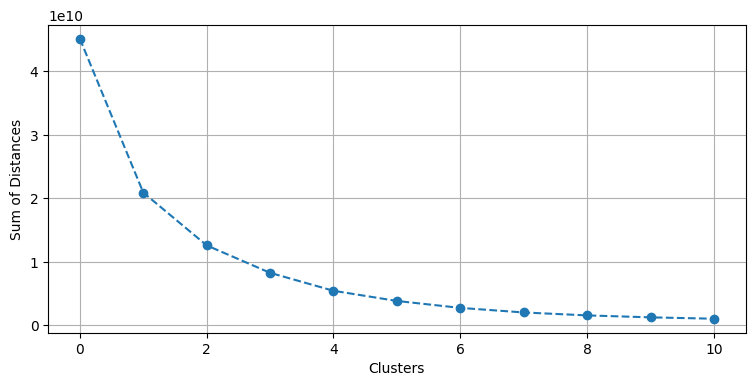

In [8]:
wcss = []
for i in range(1, 12):
    k_means = KMeans(n_clusters= i,
                     init= 'k-means++',
                     max_iter= 300,
                     n_init= 10,
                     random_state= 0,
                     tol= 0.001)
    k_means.fit(related_bounce)
    lables = k_means.labels_
    wcss.append(k_means.inertia_)

plt.figure(figsize=(9,4))
plt.plot(wcss, marker='o', linestyle='dashed')
plt.xlabel('Clusters')
plt.ylabel('Sum of Distances')
plt.grid()
plt.show()

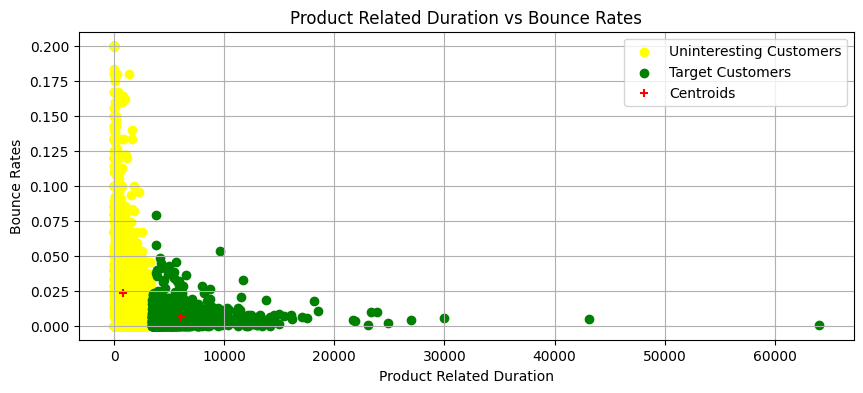

In [9]:
k_means = KMeans(n_clusters= 2,init= 'k-means++',max_iter= 300,n_init= 10,random_state= 0,tol= 0.001)
y_clusters = k_means.fit_predict(related_bounce)

plt.figure(figsize=(10,4))
plt.title('Product Related Duration vs Bounce Rates')
plt.grid()
plt.scatter(related_bounce[y_clusters == 0, 0], related_bounce[y_clusters == 0, 1], c='yellow', label="Uninteresting Customers")
plt.scatter(related_bounce[y_clusters == 1, 0], related_bounce[y_clusters == 1, 1], c='green', label="Target Customers")
plt.scatter(k_means.cluster_centers_[:,0], k_means.cluster_centers_[:,1], c='red',label="Centroids", marker='+')
plt.xlabel('Product Related Duration')
plt.ylabel('Bounce Rates')
plt.legend()
plt.show()

# PCA

In [10]:
pca_data = df
# pca_data = (pca_data - pca_data.mean()) / pca_data.std()
# print(pca_data)
pca_data=(pca_data-pca_data.min())/(pca_data.max()-pca_data.min())

pca = PCA(n_components=3)
x = pca.fit_transform(pca_data)

### Determine K after dimension reduction

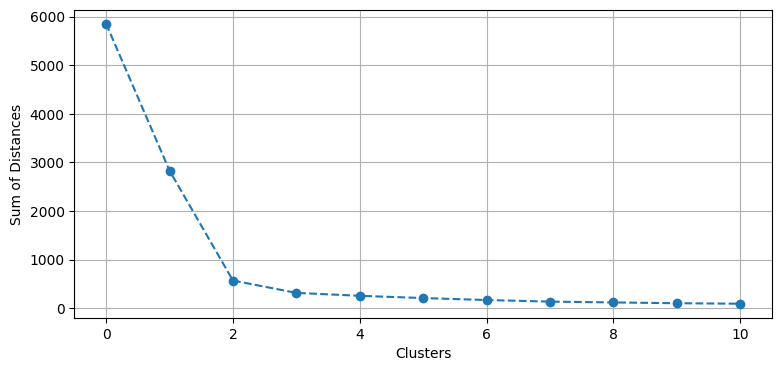

In [11]:
wcss = []
for i in range(1, 12):
    k_means = KMeans(n_clusters= i,
                     init= 'k-means++',
                     max_iter= 300,
                     n_init= 10,
                     random_state= 0,
                     tol= 0.001)
    k_means.fit(x[:,0:2])
    lables = k_means.labels_
    wcss.append(k_means.inertia_)

plt.figure(figsize=(9,4))
plt.plot(wcss, marker='o', linestyle='dashed')
plt.xlabel('Clusters')
plt.ylabel('Sum of Distances')
plt.grid()
plt.show()

### Plot transformed data and run K-means

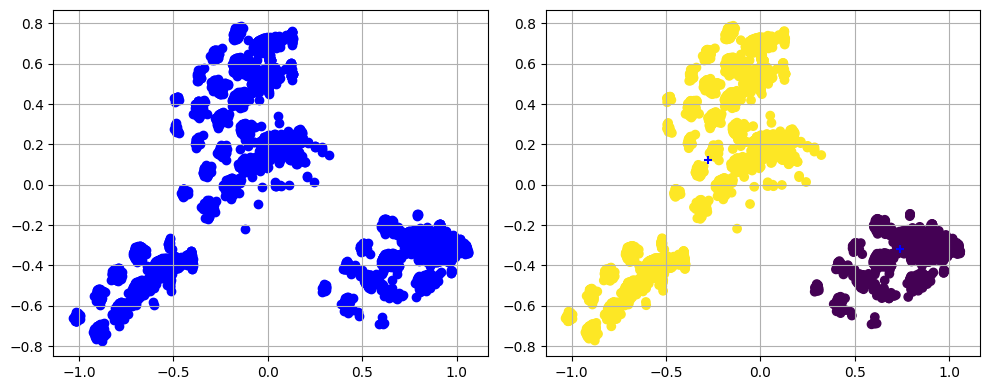

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].grid()
axs[0].scatter(x[:,0], x[:,1], c="blue", label="reduced dimension")

k_means = KMeans(n_clusters= 2,init= 'k-means++',max_iter= 300,n_init= 10,random_state= 0,tol= 0.001)
y_clusters = k_means.fit_predict(x)

axs[1].grid()
axs[1].scatter(x[:,0], x[:,1], c=y_clusters)
axs[1].scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1], c="blue", marker="+")

plt.tight_layout()  
plt.show()
# print(f'{round((len(pca_data[pca_data["Revenue"] == 0].Revenue.values) / len(pca_data["Revenue"]))*100, 2)} %')
# print(f'{round((len(pca_data[pca_data["Revenue"] == 1].Revenue.values)/ len(pca_data["Revenue"]))*100, 2)} %')

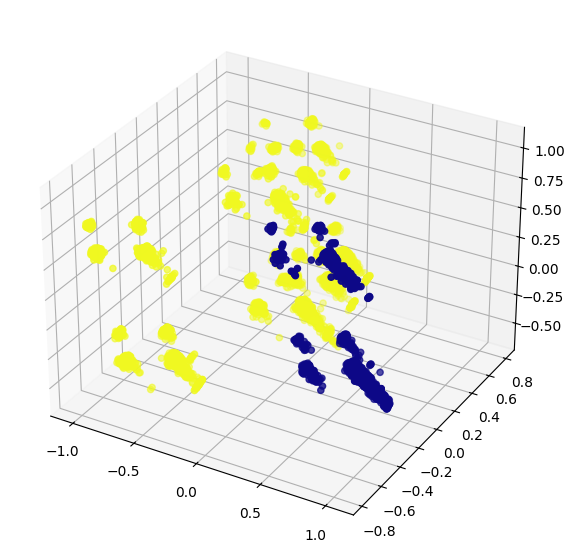

In [13]:
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
x = pca.fit_transform(pca_data)

fig = plt.figure(figsize=(7,7))
 
axis = fig.add_subplot(111, projection='3d')
axis.scatter(x[:,0],x[:,1],x[:,2], c=y_clusters, cmap='plasma')

# MLP Model

In [46]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        torch.set_default_dtype(torch.float64)
        self.linear1 = nn.Linear(input_size, 16)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(16, 8)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(8,1)
        # self.relu3 = nn.ReLU()
        # self.linear4 = nn.Linear(6,1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x_ = self.linear1(x)
        x_ = self.relu1(x_)
        x = self.dropout1(x)
        x_ = self.linear2(x_)
        x_ = self.relu2(x_)
        x_ = self.linear3(x_)
        # x_ = self.relu3(x_)
        # x_ = self.linear4(x_)
        x_ = self.sigmoid(x_)
        return x_
    
class CustomDataSet(Dataset):
    def __init__(self, dataFrame, class_column = "Revenue"):
        df = dataFrame.drop(columns=[class_column])
        # self.labels = torch.tensor(dataFrame["Revenue"].values)
        # self.labels = self.labels.double()
        # self.data = torch.tensor(df.values, dtype=torch.double)
        self.labels = dataFrame[class_column].values
        self.data = df.values
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_tensor = self.data[idx]
        labels_tensor = self.labels[idx]
        return data_tensor, labels_tensor

In [47]:
train_len = int(len(df) * 0.8)
df = (df-df.min())/(df.max()-df.min())
# df = (df - df.mean()) / df.std()
test_len = int((len(df)-train_len)/2)

train_data = df.iloc[:train_len]
test_data = df.iloc[train_len:(train_len+test_len)]
val_data = df.iloc[(train_len+test_len):]

train_set = CustomDataSet(train_data)
test_set = CustomDataSet(test_data)
val_set = CustomDataSet(val_data)

print(f'training set length: {len(train_set)}')
print(f'testing set length: {len(test_set)}')
print(f'validation set length: {len(val_set)}')

train_dataloader = DataLoader(train_set, batch_size=5, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=5, shuffle=True)
# data, label = dataset[0]
# print(data)


training set length: 9864
testing set length: 1233
validation set length: 1233


### Model preparation 

In [48]:
input_size = len(df.drop(columns=["VisitorType"]).columns)
print(f'input size: {input_size}')
model = MLP(input_size).to(device=device)
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,min_lr=1e-6, factor=0.1, verbose=True)
print(len(train_dataloader))
print(len(test_dataloader))

input size: 24
1973
247


### Model evaluation 

In [50]:
def test_model(model, validation=False):
    model.eval()
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        if not validation :
            for data, label in test_dataloader:
                data = data.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)  # Ensure labels have the correct shape
                
                # Forward pass
                output = model(data)
                
                # Converting probabilities to binary predictions (0 or 1)
                predicted_classes = (output > 0.5).float()
                
                predictions.extend(predicted_classes.view(-1).cpu().numpy())
                actuals.extend(label.view(-1).cpu().numpy())
                # Counting correct predictions
                correct_predictions += (predicted_classes == label).sum().item()
                total_predictions += label.size(0)
        else:
            for data, label in val_dataloader:
                data = data.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)  # Ensure labels have the correct shape
                
                # Forward pass
                output = model(data)
                
                # Converting probabilities to binary predictions (0 or 1)
                predicted_classes = (output > 0.5).float()
                
                predictions.extend(predicted_classes.view(-1).cpu().numpy())
                actuals.extend(label.view(-1).cpu().numpy())
                # Counting correct predictions
                correct_predictions += (predicted_classes == label).sum().item()
                total_predictions += label.size(0)
        
        # Calculating the accuracy
        accuracy = correct_predictions / total_predictions
        roc_auc = roc_auc_score(actuals, predictions)
        
        print(f'Accuracy on {"validation" if validation else "test"} set: {accuracy * 100:.2f}%')
        print(f'ROC AUC Score: {roc_auc:.2f}')
        return roc_auc, accuracy

In [51]:
NUM_EPOCHS = 64
PATH = "./model/"
loss_values = []
total_loss = 0
best_roc_auc = 0
best_model = copy.deepcopy(model.state_dict())
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    actuals = []
    predictions = []
    model.train()
    print("----------------------------------------------------------------")
    for data, label in train_dataloader:
        optimizer.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        label = label.unsqueeze(1)
        output = model(data)
        loss = loss_fn(output, label)
        
        loss.backward()
        optimizer.step()
    
        total_loss += loss.item()
        
        pred_classes = (output > 0.5).float()
        actuals.extend(label.view(-1).cpu().numpy())
        predictions.extend(pred_classes.view(-1).cpu().numpy())
    
    
    average_loss = total_loss / len(train_dataloader)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(average_loss)
    after_lr = optimizer.param_groups[0]["lr"]
    
    loss_values.append(average_loss)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {round(average_loss, 4)} | SGD lr {round(before_lr, 4)} -> {round(after_lr, 4)}')
    roc_auc, accuracy = test_model(model)
    if best_roc_auc <= roc_auc:
        best_roc_auc = roc_auc
        if os.path.exists(PATH+"bestModel.pt"):
          os.remove(PATH+"bestModel.pt")
        best_model = copy.deepcopy(model.state_dict())
        print(f'***************************************')
        print(f'*saved at acc: {round(accuracy,4)}, ROC AUC: {round(roc_auc, 4)}*')
        print(f'***************************************')
    # scheduler.step(roc_auc)
    # roc_auc = roc_auc_score(actuals, predictions)
    # print(f'ROC AUC Score: {roc_auc:.2f}')

model.load_state_dict(best_model)
        

----------------------------------------------------------------
Epoch 1/64, Loss: 0.4199 | SGD lr 0.01 -> 0.01
Accuracy on test set: 80.05%
ROC AUC Score: 0.50
***************************************
*saved at acc: 0.8005, ROC AUC: 0.5*
***************************************
----------------------------------------------------------------
Epoch 2/64, Loss: 0.3833 | SGD lr 0.01 -> 0.01
Accuracy on test set: 80.05%
ROC AUC Score: 0.50
***************************************
*saved at acc: 0.8005, ROC AUC: 0.5*
***************************************
----------------------------------------------------------------
Epoch 3/64, Loss: 0.3679 | SGD lr 0.01 -> 0.01
Accuracy on test set: 80.05%
ROC AUC Score: 0.50
***************************************
*saved at acc: 0.8005, ROC AUC: 0.5*
***************************************
----------------------------------------------------------------
Epoch 4/64, Loss: 0.3553 | SGD lr 0.01 -> 0.01
Accuracy on test set: 80.05%
ROC AUC Score: 0.50
*****

<All keys matched successfully>

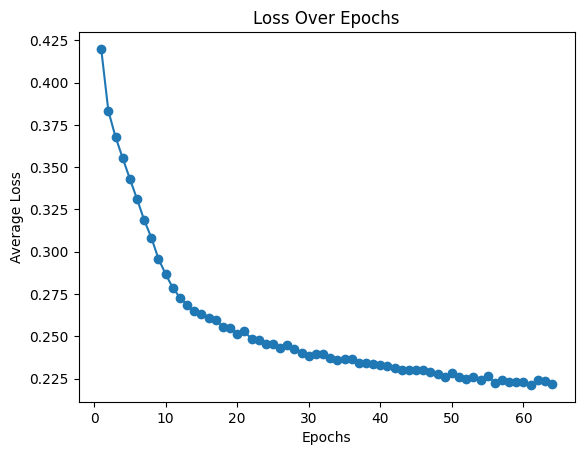

Accuracy on test set: 88.32%
ROC AUC Score: 0.79


In [52]:
plt.plot(range(1, NUM_EPOCHS + 1), loss_values, marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()
roc_auc, accuracy = test_model(model=model)

### Validating

In [54]:
test_model(model, validation=True)

Accuracy on validation set: 84.10%
ROC AUC Score: 0.72


(0.7240113803831669, 0.8410381184103812)

In [126]:

new_visitor_set = csv_data
new_visitor_set = new_visitor_set.drop(columns=['OperatingSystems', "Browser"])
# hot_encoded_dict = 
new_visitor_set = pd.get_dummies(new_visitor_set, columns=["Month"])
new_visitor_set = new_visitor_set.iloc[train_len:]
new_visitor_set = new_visitor_set[new_visitor_set["VisitorType"] == "New_Visitor"]
new_visitor_set["VisitorType"] = new_visitor_set["VisitorType"].map(lambda x: df_customers_dict[x])

new_visitor_set = new_visitor_set.map(lambda x: int(x) if isinstance(x, bool) else x)

# new_visitor_set[new_visitor_set["Revenue"] == 1]
new_visitor_set = (new_visitor_set-new_visitor_set.min())/(new_visitor_set.max()-new_visitor_set.min())
new_visitor_set["VisitorType"] = 0




# new_visitor_set = (new_visitor_set - new_visitor_set.mean()) / new_visitor_set.std()
# IDX = 1
# print(new_visitor_set[new_visitor_set["Revenue"] == 1])
all_true = 0
true_pos = 0
# print(new_visitor_set["Revenue"].values[:100])
for IDX in range(100):
    test_sample_y = new_visitor_set.iloc[IDX]["Revenue"]
    test_sample = new_visitor_set.iloc[IDX]
    test_sample = test_sample.drop('Revenue')
    
    test_sample = test_sample.fillna(0)
    test_sample = test_sample.values

    test_sample = torch.tensor(test_sample).to(device)
    test_sample_y = torch.tensor(test_sample_y).float().to(device)

    
    model.eval()

    with torch.no_grad():
        output = model(test_sample)
        # Converting probabilities to binary predictions (0 or 1)
        predicted_classes = (output > 0.5).float()
        predicted_classes = predicted_classes.unsqueeze(-1)
        print(f'Actual class: {test_sample_y.item()}')
        print(f'Predicted class: {predicted_classes.item()}')
        
        if test_sample_y.item() == 1:
            all_true += 1
            if predicted_classes.item() == 1:
                true_pos += 1
                
print(all_true)
print(true_pos)

    



Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 1.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 1.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 1.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 1.0
Predicted class: 1.0
Actual class: 1.0
Predicted class: 1.0
Actual class: 1.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 0.0
Predicted class: 1.0
Actual class: 0.0
Predicted class: 0.0
Actual class: 1.0
Predicted class: 1.0
Actual class: 1.0
Predicted class: 0.0
Actual class: 0.0
Predict

## Outbalance Data and train again

from sklearn.utils import shuffle

class_1 = df[df["Revenue"] == 1]
class_0 = df[df["Revenue"] == 0].iloc[:len(class_1)]

balanced_set = pd.concat([class_0, class_1])
balanced_set = shuffle(balanced_set)

train_len = int(len(balanced_set) * 0.8)

train_balanced_data = balanced_set.iloc[:train_len]
test_balanced_data = balanced_set.iloc[train_len:]
train_balanced_set = CustomDataSet(train_balanced_data)
test_balanced_set = CustomDataSet(test_balanced_data)

train_balanced_dataloader = DataLoader(train_balanced_set, batch_size=2, shuffle=True)
test_balanced_dataloader = DataLoader(test_balanced_set, batch_size=2, shuffle=True)

model_2 = MLP(input_size).to(device=device)
loss_fn_2 = nn.BCELoss()
optimizer_2 = optim.SGD(model_2.parameters(), lr=1e-1)
scheduler_2 = lr_scheduler.ReduceLROnPlateau(optimizer_2,min_lr=1e-6, factor=0.1, verbose=True)
print(len(train_balanced_dataloader))
print(len(test_balanced_dataloader))

def test_model_2(model_2):
    model_2.eval()
    
    predictions = []
    actuals = []
    
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        
        for data, label in test_balanced_dataloader:
            data = data.to(device)
            label = label.to(device)
            label = label.unsqueeze(1)  # Ensure labels have the correct shape
            
            # Forward pass
            output = model_2(data)
            
            # Converting probabilities to binary predictions (0 or 1)
            predicted_classes = (output > 0.5).float()
            
            predictions.extend(predicted_classes.view(-1).cpu().numpy())
            actuals.extend(label.view(-1).cpu().numpy())
            # Counting correct predictions
            correct_predictions += (predicted_classes == label).sum().item()
            total_predictions += label.size(0)
        
        # Calculating the accuracy
        accuracy = correct_predictions / total_predictions
        print(f'Accuracy on test set: {accuracy * 100:.2f}%')
        
        # print(actuals)
        # print(predictions)
        roc_auc = roc_auc_score(actuals, predictions)
        print(f'ROC AUC Score: {roc_auc:.2f}')
        return roc_auc, accuracy

NUM_EPOCHS = 64
PATH = "./model/"
loss_values = []
total_loss = 0
best_roc_auc = 0
best_model_2 = copy.deepcopy(model_2.state_dict())
for epoch in range(NUM_EPOCHS):
    total_loss = 0
    actuals = []
    predictions = []
    model_2.train()
    print("----------------------------------------------------------------")
    for data, label in train_balanced_dataloader:
        optimizer_2.zero_grad()
        
        data = data.to(device)
        label = label.to(device)
        label = label.unsqueeze(1)
        output = model_2(data)
        loss = loss_fn_2(output, label)
        
        loss.backward()
        optimizer_2.step()
    
        total_loss += loss.item()
        
        pred_classes = (output > 0.5).float()
        actuals.extend(label.view(-1).cpu().numpy())
        predictions.extend(pred_classes.view(-1).cpu().numpy())
    
    
    average_loss = total_loss / len(train_balanced_dataloader)
    
    before_lr = optimizer.param_groups[0]["lr"]
    scheduler_2.step(average_loss)
    after_lr = optimizer.param_groups[0]["lr"]
    
    loss_values.append(average_loss)
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {round(average_loss, 4)} | SGD lr {round(before_lr, 4)} -> {round(after_lr, 4)}')
    roc_auc, accuracy = test_model_2(model_2)
    if best_roc_auc <= roc_auc:
        best_roc_auc = roc_auc
        if os.path.exists(PATH+"bestModel.pt"):
          os.remove(PATH+"bestModel.pt")
        best_model_2 = copy.deepcopy(model_2.state_dict())
        print(f'***************************************')
        print(f'*saved at acc: {round(accuracy,4)}, ROC AUC: {round(roc_auc, 4)}*')
        print(f'***************************************')
    # scheduler.step(roc_auc)
    # roc_auc = roc_auc_score(actuals, predictions)
    # print(f'ROC AUC Score: {roc_auc:.2f}')

model_2.load_state_dict(best_model_2)
        

plt.plot(range(1, NUM_EPOCHS + 1), loss_values, marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.show()
roc_auc, accuracy = test_model_2(model_2=model_2)


new_visitor_set = csv_data
new_visitor_set = new_visitor_set.drop(columns=['OperatingSystems', "Browser"])
# hot_encoded_dict = 
new_visitor_set = pd.get_dummies(new_visitor_set, columns=["Month"])
new_visitor_set = new_visitor_set.iloc[train_len:]
new_visitor_set = new_visitor_set[new_visitor_set["VisitorType"] == "New_Visitor"]
new_visitor_set["VisitorType"] = new_visitor_set["VisitorType"].map(lambda x: df_customers_dict[x])

new_visitor_set = new_visitor_set.map(lambda x: int(x) if isinstance(x, bool) else x)

# new_visitor_set[new_visitor_set["Revenue"] == 1]
new_visitor_set = (new_visitor_set-new_visitor_set.min())/(new_visitor_set.max()-new_visitor_set.min())
new_visitor_set["VisitorType"] = 0




# new_visitor_set = (new_visitor_set - new_visitor_set.mean()) / new_visitor_set.std()
# IDX = 1
# print(new_visitor_set[new_visitor_set["Revenue"] == 1])
all_true = 0
true_pos = 0
# print(new_visitor_set["Revenue"].values[:100])
for IDX in range(100):
    test_sample_y = new_visitor_set.iloc[IDX]["Revenue"]
    test_sample = new_visitor_set.iloc[IDX]
    test_sample = test_sample.drop('Revenue')
    
    test_sample = test_sample.fillna(0)
    test_sample = test_sample.values
    test_sample = torch.tensor(test_sample).to(device)
    test_sample_y = torch.tensor(test_sample_y).float().to(device)


    model_2.eval()

    with torch.no_grad():
        output = model_2(test_sample)

        # Converting probabilities to binary predictions (0 or 1)
        predicted_classes = (output > 0.5).float()
        predicted_classes = predicted_classes.unsqueeze(-1)
        print(f'Actual class: {test_sample_y.item()}')
        print(f'Predicted class: {predicted_classes.item()}')
        
        if test_sample_y.item() == 1:
            all_true += 1
            if predicted_classes.item() == 1:
                true_pos += 1
                
print(all_true)
print(true_pos)

    

